In [2]:
import healpy as hp
import bigfile
#from scipy import *
import numpy as np
from pylab import *
import os
from astropy.io import fits
import matplotlib.pyplot as plt
from datetime import date
%matplotlib inline

In [ ]:
import os
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import bigfile

In [3]:
sys.path.append('/lustre/work/akira.tokiwa/Projects/LensingSSC/lib/code/CAMB')
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.5.4 installed at /lustre/work/akira.tokiwa/Projects/LensingSSC/lib/code/CAMB/camb


In [4]:
######## check TT, Pk (z=0), Clkk (z=1) from class vs camb

# LCDM parameters
A_s = 2.1e-9
h=0.7
OmegaB = 0.046
OmegaM = 0.3
n_s = 0.97
tau = 0.054 ## only for primary CMB, not used for now, for simplicity

# beyond LCDM, not implemented yet
OmegaDE = 0.75
w0=-1.0#-0.5#
wa=0.0#0.1#
Neff = 3.046
mnu = 0.0

### derived parameters
#z_reio = 10.0 #11.357
ombh2 = OmegaB*h**2
omch2 = (OmegaM-OmegaB)*h**2
H0=h*100
### accuracy parameters
lmax=5000

In [6]:
def gen_clkk(zs, folder="/lustre/work/akira.tokiwa/Projects/LensingSSC/data"):
    """
    Generates the power spectrum (Cl) of the kappa field from a bigfile dataset.

    Parameters:
    zs (float): Redshift
    folder (str): Directory path where the dataset is stored

    Returns:
    None: The function saves the power spectrum to a file and does not return any value.
    """
    
    file = bigfile.File(f'{folder}/wlen/WL-{zs:.2f}-N0512')
    nside = file['kappa'].attrs['nside'][0]
    zs = file['kappa'].attrs['zs'][0]
    
    lmax = min([1000, nside])
    ell_sim = np.arange(lmax + 1)
    
    fn_cl = f'{folder}/kappa_cl_z{zs:.2f}.npz'
    
    if not os.path.isfile(fn_cl):
        cl = hp.anafast(file['kappa'][:], lmax=lmax)
        np.savez(fn_cl, ell=ell_sim, cl=cl)

In [1]:
##########################
####### camb #############
##########################

def calc_cl(h, ombh2, omch2, mnu, w0, wa, A_s, n_s, lmax):
    """
    Calculate the power spectra and source classes using the CAMB library.

    Parameters:
    h, ombh2, omch2, mnu, w0, wa, A_s, n_s, lmax (float): cosmological parameters

    Returns:
    tuple: arrays representing the calculated powers and classes
    """

    # Set up a new set of parameters for CAMB
    pars = camb.CAMBparams()

    # This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
    pars.set_cosmology(H0=h*100, ombh2=ombh2, omch2=omch2, omk=0, tau=0, mnu=mnu, neutrino_hierarchy='normal')

    # Dark energy settings
    pars.set_dark_energy(w=w0, wa=wa, dark_energy_model='fluid')

    pars.InitPower.set_params(As=A_s, ns=n_s, r=0)
    pars.set_matter_power(redshifts=[0., ], kmax=10.0)
    pars.set_for_lmax(lmax, lens_potential_accuracy=0)
    pars.SourceWindows = [camb.sources.GaussianSourceWindow(redshift=1.0, source_type='lensing', sigma=0.0001), ]

    # Calculate results for these parameters
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit='K')

    # Primary CMB
    unlensedCL = powers['unlensed_scalar'][:, 0]
    ls = np.arange(unlensedCL.shape[0])

    # Pk
    kcamb, zcamb, Pkcamb = results.get_matter_power_spectrum(minkh=1e-3, maxkh=10, npoints=200)

    # Clkk
    cls_Wz = results.get_source_cls_dict()
    clkk_camb = cls_Wz['W1xW1'][2:]

    return ls, unlensedCL, kcamb, zcamb, Pkcamb, clkk_camb

# Kappa

In [7]:
zs_list = [0.5, 1.0, 2.0]
for zs in zs_list:
    gen_clkk(zs)

In [10]:
ls, unlensedCL, kcamb, zcamb, Pkcamb, clkk_camb = calc_cl(h, ombh2, omch2, mnu, w0, wa, A_s, n_s, lmax)

In [11]:
def gen_comp(zs, folder='/lustre/work/akira.tokiwa/Projects/LensingSSC/data'):
    """
    Generate a comparison plot of the power spectra from simulation and CAMB calculation.

    Parameters:
    zs (float): Redshift
    folder (str): Directory path where the dataset is stored

    Returns:
    None: The function generates a plot and does not return any value.
    """

    # Load simulation power spectrum
    data = np.load(f'{folder}/kappa_cl_z{zs:.2f}.npz')
    ell_sim, cl_sim = data['ell'], data['cl']

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(6,3))

    # Set axis scale and labels
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\ell$', fontsize=16)
    ax.set_ylabel(r'$[\ell(\ell+1)/2\pi]  C_\ell^\mathrm{kk}$', fontsize=16)

    # Plot simulation power spectrum
    ax.plot(ell_sim, cl_sim*ell_sim*(ell_sim+1)/2./np.pi, 'k-', lw=1, alpha=0.6, label=f'Clkk CrownCanyon (z_s={zs})')

    # Add legend and title
    ax.legend(loc=0, frameon=0)
    ax.set_title(f'z_s={zs}')

    plt.show()

In [27]:
def gen_comp(zs, folder = '/lustre/work/akira.tokiwa/Projects/LensingSSC/data'):
    ####### load sim cl
    #data=load("crowcanyon_zs2.0_4096_cls.npz")
    data=load(folder+'/kappa_cl_z%.2f.npz'%(zs))
    ell_sim, cl_sim=data['ell'], data['cl']

    ####### compute halofit curve
    """
    fn_cl_camb = 'kappa_cl_camb_z%.2f.npz'%(zs)
    if not os.path.isfile(fn_cl_camb):
        ell, clkk, clkk_lin = calc_cl(zs)
        np.savez(fn_cl_camb, ell=ell, clkk = clkk, clkk_lin=clkk_lin)
    data=load(fn_cl_camb)
    ell, clkk, clkk_lin = data['ell'], data['clkk'], data['clkk_lin']
    """

    fig, ax = plt.subplots(figsize=(6,3))

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\ell$', fontsize=16)
    ax.set_ylabel(r'$[\ell(\ell+1)/2\pi]  C_\ell^\mathrm{kk}$', fontsize=16)

    # ax.plot(ell, clkk_lin*ell*(ell+1)/2./np.pi, 'c--', lw=3, alpha=0.5, label='Clkk linear (z_s=%s)' % (zs))
    # ax.plot(ell, clkk*ell*(ell+1)/2./np.pi, 'g-', lw=3, alpha=0.5, label='Clkk halofit (z_s=%s)' % (zs))
    ax.plot(ell_sim, cl_sim*ell_sim*(ell_sim+1)/2./np.pi, 'k-', lw=1, alpha=0.6, label='Clkk CrownCanyon (z_s=%s)' % (zs))
    # ax.plot(ls2, clkk_camb, 'b-', label='camb')

    ax.legend(loc=0, frameon=0)
    ax.set_title('z_s=%s'%(zs))

    plt.show()
    fig.savefig('clkk_zs%.2f.png'%(zs), bbox_inches='tight')

In [8]:
zs = 0.5
folder="/lustre/work/akira.tokiwa/Projects/LensingSSC/data"
f = bigfile.File(folder + '/wlen/WL-%.2f-N0512'%(zs))

nside = f['kappa'].attrs['nside'][0] 
zmin  = f['kappa'].attrs['zlmin'][0] 
zmax  = f['kappa'].attrs['zlmax'][0] 
#zstep = f['kappa'].attrs['zstep'][0] 
zs    = f['kappa'].attrs['zs'][0] 

print('nside = ', nside)
print('redshifts = ', zs)

lmax = min([1000,nside])#5000
ell_sim = np.arange(lmax+1)
print(f['kappa'][:].shape)

nside =  512
redshifts =  0.5
(3145728,)


In [13]:
sample = f['kappa'][:]

In [19]:
type(sample)

numpy.ndarray

ValueError: Passing a Normalize instance simultaneously with vmin/vmax is not supported.  Please pass vmin/vmax directly to the norm when creating it.

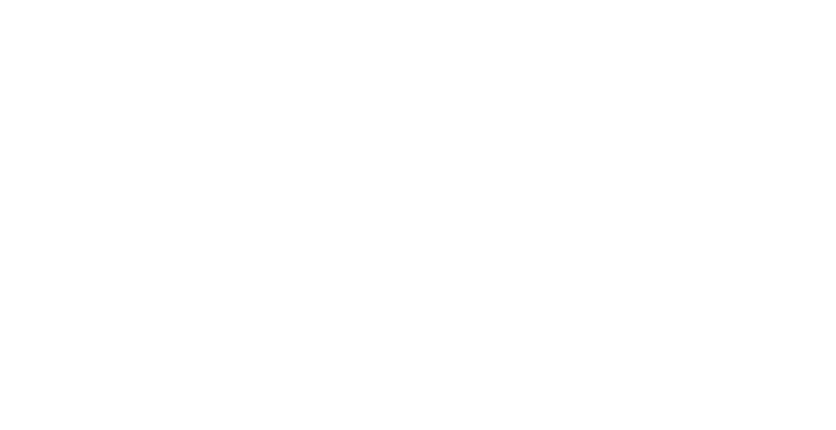

In [18]:
hp.mollview(sample)

/lustre/work/akira.tokiwa/Projects/LensingSSC/env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  fig.canvas.print_figure(bytes_io, **kw)


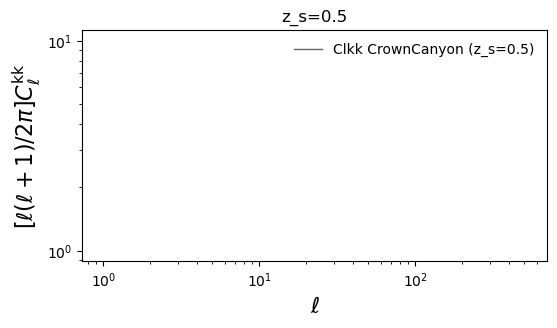

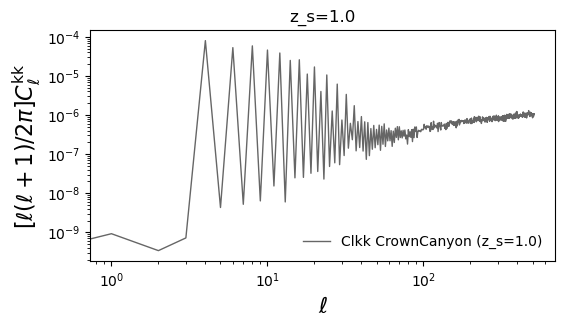

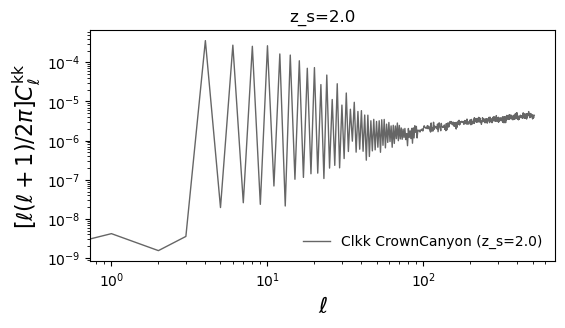

In [29]:
for zs in zs_list:
    gen_comp(zs)